In [1]:
!pip install sacrebleu
!pip install nltk rouge-score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=06e5932dd0e918bc847e11d0566a4c5b761eff8e4e487017abefbba695549bf4
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# Check the number of available GPUs
num_gpus = len(tf.config.list_physical_devices('GPU'))
print(f"Number of GPUs available: {num_gpus}")

# Ensure that a GPU is being used
physical_devices = tf.config.list_physical_devices('GPU')

if num_gpus > 0:
    # Enable memory growth for each GPU
    for device in physical_devices:
        tf.config.set_memory_growth(device, True)
    print("GPUs are available for training!")
else:
    print("No GPU detected. The CPU will be used for training.")

# Set mixed precision policy for faster training
precision_policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(precision_policy)


Num GPUs Available:  1
GPU(s) are available for training!


# Data Preprocessing

In [ ]:
import tensorflow as tf
import sentencepiece as spm
import numpy as np
import os

# Paths for data
train_en_dir = '/kaggle/input/english-urdu-translation-data/English2Urdu Data/train/English/'
train_ur_dir = '/kaggle/input/english-urdu-translation-data/English2Urdu Data/train/Urdu/'

test_en_dir = '/kaggle/input/english-urdu-translation-data/English2Urdu Data/test/English/'
test_ur_dir = '/kaggle/input/english-urdu-translation-data/English2Urdu Data/test/Urdu/'

# Function to read content from a file
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.readlines()

# Load training data by combining English and Urdu sentences
train_en = read_file(os.path.join(train_en_dir, 'bible_train.en')) + read_file(os.path.join(train_en_dir, 'quran_train.en'))
train_ur = read_file(os.path.join(train_ur_dir, 'bible_train.ur')) + read_file(os.path.join(train_ur_dir, 'quran_train.ur'))

# Load testing data similarly
test_en = read_file(os.path.join(test_en_dir, 'bible_test.en')) + read_file(os.path.join(test_en_dir, 'quran_test.en'))
test_ur = read_file(os.path.join(test_ur_dir, 'bible_test.ur')) + read_file(os.path.join(test_ur_dir, 'quran_test.ur'))

# Function to train a SentencePiece model
def train_sentencepiece_model(input_data, model_prefix, vocab_size=5000):
    # Write the data to a temporary file for SentencePiece training
    with open(f"{model_prefix}.txt", "w", encoding="utf-8") as temp_file:
        for sentence in input_data:
            temp_file.write(sentence.strip() + "\n")
    
    # Train the SentencePiece model
    spm.SentencePieceTrainer.train(f'--input={model_prefix}.txt --model_prefix={model_prefix} --vocab_size={vocab_size}')

# Train SentencePiece models for English and Urdu
train_sentencepiece_model(train_en, "en_spm")
train_sentencepiece_model(train_ur, "ur_spm")

# Load the trained SentencePiece models
sp_en = spm.SentencePieceProcessor(model_file='en_spm.model')
sp_ur = spm.SentencePieceProcessor(model_file='ur_spm.model')

# Function to tokenize and pad sentences
def tokenize_and_pad(sentences, sp_model, max_length=30):
    # Tokenize each sentence using the SentencePiece model
    tokenized = [sp_model.encode(sentence, out_type=int) for sentence in sentences]
    # Pad the sequences to ensure consistent length
    padded = tf.keras.preprocessing.sequence.pad_sequences(tokenized, padding='post', maxlen=max_length, truncating='post')
    return np.array(padded)

# Tokenizing and padding training and test data
train_en_tokenized = tokenize_and_pad(train_en, sp_en)
train_ur_tokenized = tokenize_and_pad(train_ur, sp_ur)
test_en_tokenized = tokenize_and_pad(test_en, sp_en)
test_ur_tokenized = tokenize_and_pad(test_ur, sp_ur)

# Print the shapes of the tokenized and padded data
print(f"Tokenized English training data shape: {train_en_tokenized.shape}")
print(f"Tokenized Urdu training data shape: {train_ur_tokenized.shape}")
print(f"Tokenized English test data shape: {test_en_tokenized.shape}")
print(f"Tokenized Urdu test data shape: {test_ur_tokenized.shape}")


sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=en_spm.txt --model_prefix=en_spm --vocab_size=5000
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: en_spm.txt
  input_format: 
  model_prefix: en_spm
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
 

Tokenized English training data shape: (13400, 30)
Tokenized Urdu training data shape: (13400, 30)
Tokenized English test data shape: (457, 30)
Tokenized Urdu test data shape: (457, 30)


In [ ]:
# Print the original sentence and the tokenized version for comparison
print(f"Original sentence: {train_en[0]}")
print(f"Tokenized: {train_en_tokenized[0]}")

# Filter out padding tokens (which are 0) from the tokenized sentence
filtered_tokens = [token for token in train_en_tokenized[0] if token != 0]

# Convert the filtered tokens into a numpy array of integers
filtered_tokens_array = np.array(filtered_tokens, dtype=int)

# Decode the filtered tokens back to the sentence using the SentencePiece model
decoded_sentence = sp_en.decode(filtered_tokens_array.tolist())  # Convert array to list for decoding

# Print the decoded sentence (without padding)
print(f"Decoded without padding: {decoded_sentence}")


Original sentence: ﻿The book of the generation of Jesus Christ , the son of David , the son of Abraham .

Tokenized: [  45 1447   11    4  752   11   85   64  130    5    4  206   11  629
  638    5    4  206   11  343    7    0    0    0    0    0    0    0
    0    0]
Decoded without padding: The book of the generation of Jesus Christ , the son of David , the son of Abraham .


In [5]:
import pandas as pd

# Create a combined DataFrame
data = pd.DataFrame({
    'Dataset': ['Train'] * len(train_en_tokenized) + ['Test'] * len(test_en_tokenized),
    'English (Tokenized & Padded)': train_en_tokenized.tolist() + test_en_tokenized.tolist(),
    'Urdu (Tokenized & Padded)': train_ur_tokenized.tolist() + test_ur_tokenized.tolist()
})

# Display the first few rows of the DataFrame
data

,Dataset,English (Tokenized & Padded),Urdu (Tokenized & Padded)
0,Train,"[45, 1447, 11, 4, 752, 11, 85, 64, 130, 5, 4, ...","[111, 91, 158, 170, 97, 2217, 145, 170, 97, 93..."
1,Train,"[343, 446, 23, 634, 585, 3, 4988, 3, 8, 634, 5...","[535, 256, 8, 23, 443, 599, 177, 204, 4, 23, 4..."
2,Train,"[17, 611, 6, 446, 23, 4552, 257, 3, 8, 3, 0, 3...","[4, 773, 15, 16, 8, 2763, 1857, 4, 1948, 89, 2..."
3,Train,"[17, 161, 2138, 446, 23, 4087, 1729, 1242, 3, ...","[4, 417, 256, 8, 3236, 2955, 122, 177, 204, 4,..."
4,Train,"[17, 4001, 446, 23, 4490, 1646, 11, 1401, 1353...","[4, 3376, 8, 1063, 2725, 4875, 110, 8, 177, 20..."
...,...,...,...
13852,Test,"[146, 20, 4, 855, 11, 3, 9, 48, 10, 65, 684, 7...","[29, 58, 47, 9, 32, 238, 12, 5, 0, 0, 0, 0, 0,..."
13853,Test,"[146, 20, 4, 69, 11, 4, 3, 9, 479, 10, 693, 3,...","[29, 289, 11, 985, 1477, 32, 369, 12, 5, 0, 0,..."
13854,Test,"[590, 1351, 4, 202, 11, 3831, 513, 1024, 22, 2...","[1892, 16, 1067, 450, 7, 412, 8, 29, 45, 59, 7..."
13855,Test,"[146, 2360, 6, 97, 4, 171, 6, 11, 65, 684, 7, ...","[29, 47, 9, 7, 167, 9, 13, 6, 1892, 16, 197, 7..."


# Model Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
import numpy as np

# Hyperparameters
embedding_dim = 128
hidden_units = 128
num_heads = 5
num_layers = 6
dropout_rate = 0.2  # Increased dropout
max_seq_len = 50  # Max sequence length


# Custom multi-head attention layer implementation
class CustomMultiHeadAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(CustomMultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.attention_layer = layers.MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.key_dim,
            dropout=0.1
        )

    def call(self, query, value, key=None, attention_mask=None, return_attention_scores=False):
        # Compute multi-head attention
        output, scores = self.attention_layer(
            query, value, attention_mask=attention_mask, return_attention_scores=True
        )

        if return_attention_scores:
            return output, scores
        return output


# Positional encoding function
def generate_positional_encoding(seq_len, embedding_dim):
    position = np.arange(seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, embedding_dim, 2) * -(np.log(10000.0) / embedding_dim))
    pos_enc = np.zeros((seq_len, embedding_dim))
    pos_enc[:, 0::2] = np.sin(position * div_term)
    pos_enc[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pos_enc, dtype=tf.float32)


# Custom layer to apply positional encoding
@keras.utils.register_keras_serializable()
class PositionalEncoding(layers.Layer):
    def __init__(self, max_seq_len, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.pos_enc = generate_positional_encoding(max_seq_len, embedding_dim)

    def call(self, inputs):
        seq_len = tf.shape(inputs)[1]  # Get the sequence length from the inputs
        pos_enc = self.pos_enc[:seq_len, :]  # Slice positional encodings to match sequence length
        pos_enc = tf.cast(pos_enc, inputs.dtype)  # Cast to the dtype of inputs
        return inputs + pos_enc  # Add positional encoding to input


# Encoder Layer with feedforward network and attention
def transformer_encoder(inputs, hidden_units, num_heads, dropout_rate, return_attention=False):
    # Multi-head self-attention layer
    attention_layer = CustomMultiHeadAttention(num_heads=num_heads, key_dim=hidden_units)
    attention_output, attention_scores = attention_layer(inputs, inputs, return_attention_scores=True)
    
    # Apply dropout and layer normalization
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    attention_output = layers.LayerNormalization()(inputs + attention_output)

    # Feed-forward layer
    ff_output = layers.Dense(hidden_units * 4, activation='relu')(attention_output)
    ff_output = layers.Dense(hidden_units)(ff_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.LayerNormalization()(attention_output + ff_output)

    if return_attention:
        return ff_output, attention_scores  # Return both output and attention scores
    return ff_output


# Decoder Layer with attention and feedforward network
def transformer_decoder(inputs, enc_outputs, hidden_units, num_heads, dropout_rate, return_attention=False):
    # Self-attention on decoder inputs
    attention1_layer = CustomMultiHeadAttention(num_heads=num_heads, key_dim=hidden_units)
    attention1_output, attention1_scores = attention1_layer(inputs, inputs, return_attention_scores=True)
    attention1_output = layers.Dropout(dropout_rate)(attention1_output)
    attention1_output = layers.LayerNormalization()(inputs + attention1_output)

    # Cross-attention (encoder-decoder attention)
    attention2_layer = CustomMultiHeadAttention(num_heads=num_heads, key_dim=hidden_units)
    attention2_output, attention2_scores = attention2_layer(attention1_output, enc_outputs, return_attention_scores=True)
    attention2_output = layers.Dropout(dropout_rate)(attention2_output)
    attention2_output = layers.LayerNormalization()(attention1_output + attention2_output)

    # Feed-forward layer
    ff_output = layers.Dense(hidden_units * 4, activation='relu')(attention2_output)
    ff_output = layers.Dense(hidden_units)(ff_output)
    ff_output = layers.Dropout(dropout_rate)(ff_output)
    ff_output = layers.LayerNormalization()(attention2_output + ff_output)

    if return_attention:
        return ff_output, [attention1_scores, attention2_scores]
    
    return ff_output


# Complete Transformer Model with positional encoding and attention
def build_transformer(input_vocab_size, target_vocab_size, embedding_dim, num_layers, hidden_units, num_heads, dropout_rate, max_seq_len=500, return_attention=False):
    inputs = layers.Input(shape=(None,))
    targets = layers.Input(shape=(None,))

    # Embedding layers for inputs and targets
    encoder_embedding = layers.Embedding(input_vocab_size, embedding_dim)(inputs)
    decoder_embedding = layers.Embedding(target_vocab_size, embedding_dim)(targets)

    # Add positional encoding to embeddings
    pos_enc_layer = PositionalEncoding(max_seq_len, embedding_dim)
    encoder_embedding = pos_enc_layer(encoder_embedding)
    decoder_embedding = pos_enc_layer(decoder_embedding)

    # Encoder layers
    encoder_output = encoder_embedding
    all_attention_weights = []
    for _ in range(num_layers):
        encoder_output, attention = transformer_encoder(encoder_output, hidden_units, num_heads, dropout_rate, return_attention=True)
        all_attention_weights.append(attention)

    # Decoder layers
    decoder_output = decoder_embedding
    for _ in range(num_layers):
        decoder_output, attention = transformer_decoder(decoder_output, encoder_output, hidden_units, num_heads, dropout_rate, return_attention=True)
        all_attention_weights.append(attention)

    # Output layer for logits
    logits = layers.Dense(target_vocab_size)(decoder_output)

    # Define and compile the model
    model = models.Model(inputs=[inputs, targets], outputs=[logits, all_attention_weights] if return_attention else logits)
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
from tensorflow.keras import regularizers

# Build model
input_vocab_size = len(sp_en)
target_vocab_size = len(sp_ur)
model = build_transformer_model(input_vocab_size, target_vocab_size, embedding_dim, num_layers, hidden_units, num_heads, dropout_rate)

# Hyperparameter Tuning

In [24]:
# Enable eager execution if not already enabled
if not tf.executing_eagerly():
    tf.compat.v1.enable_eager_execution()

# Updated Hyperparameters and Training Setup
batch_size = 128  # Smaller batch size
epochs = 15
learning_rate = 1e-4  # Use a scheduler to decrease over epochs

# Define a custom learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=learning_rate,
    decay_steps=1000,
    decay_rate=0.95,
    staircase=True
)

# Compile model with learning rate scheduler
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train model on GPU (if available)
history = model.fit(
    x=[train_en_tokenized, train_ur_tokenized[:, :-1]],  # Use `train_ur_tokenized[:, :-1]` for shifted target input
    y=train_ur_tokenized[:, 1:],  # Shifted target data
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/15


W0000 00:00:1731761263.010640     300 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0884 - loss: 7.9775

W0000 00:00:1731761420.530963     302 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0885 - loss: 7.9732  

W0000 00:00:1731761577.202062     301 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731761580.236590     302 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


95/95 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.0887 - loss: 7.9690 - val_accuracy: 0.2538 - val_loss: 6.4801
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.1311 - loss: 6.4874 - val_accuracy: 0.2643 - val_loss: 5.5032
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.1354 - loss: 5.7518 - val_accuracy: 0.2796 - val_loss: 5.0512
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.1460 - loss: 5.4812 - val_accuracy: 0.3006 - val_loss: 4.7690
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.1768 - loss: 5.2837 - val_accuracy: 0.3193 - val_loss: 4.5022
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.2003 - loss: 5.0479 - val_accuracy: 0.3370 - val_loss: 4.2636
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.2286 - loss: 4.8223 - val_accuracy: 0.3688 - val_loss: 4.0363
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step - accuracy: 0.2620 - loss: 4.5936 - val_accuracy: 0.3942 

In [20]:
import time
import os

# Create a directory for saving the model (if it doesn't exist)
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Create a unique name for the model based on timestamp or other identifiers
timestamp = int(time.time())
model_filename = os.path.join(model_dir, f"model_trasnformer.keras")

# Save the model in the TensorFlow SavedModel format
model.save(model_filename)

print(f"Model saved in TensorFlow .tf format at {model_filename}")

Model saved in TensorFlow .tf format at saved_models/model_trasnformer.keras


# Translation and Evaluation with BLEU and ROUGE

In [ ]:
import numpy as np

def translate(model, input_seq, target_sp_model, max_length=25, start_token=1, end_token=2):
    """
    Translate a sequence using the trained model.

    :param model: Trained model
    :param input_seq: Input sequence (tokenized format of English sentence)
    :param target_sp_model: SentencePiece model for the target language (Urdu)
    :param max_length: Maximum length of the translation
    :param start_token: Token ID for the start of the sentence (usually 1 for many models)
    :param end_token: Token ID for the end of the sentence (usually 2 for many models)
    :return: Translated sentence in the target language
    """
    # Add batch dimension to the input sequence
    input_seq = np.expand_dims(input_seq, axis=0)
    
    # Prepare initial decoder input (start token)
    decoder_input = np.array([[start_token]])  # Start with the start token
    
    translated_tokens = []  # To store translated tokens
    
    # Loop to generate each token in the sequence up to max_length
    for _ in range(max_length):
        # Predict the next token
        prediction = model.predict([input_seq, decoder_input], verbose=0)  # Pass both encoder and decoder inputs
        predicted_token = np.argmax(prediction[0, -1, :])  # Take the token with the highest probability

        if predicted_token == end_token:
            break  # Stop if the end token is generated

        # Append the predicted token to the list of translated tokens
        translated_tokens.append(predicted_token)
        
        # Update the decoder input for the next token (append the predicted token)
        decoder_input = np.hstack([decoder_input, np.array([[predicted_token]])])  # Append token for next step
    
    # Decode the predicted token sequence to the target language words
    decoded_sentence = target_sp_model.decode(translated_tokens)
    
    return decoded_sentence

# Example usage
example_input = test_en_tokenized[10]  # First test sentence (tokenized)
translated_output = translate(model, example_input, sp_ur)

print("Input (English):", test_en[10])
print("Translation (Predicted Urdu):", translated_output)


/opt/conda/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 5, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Input (English): And the four angels were loosed , which were prepared for an hour , and a day , and a month , and a year , for to slay the third part of men .

Translation (Predicted Urdu): جنک جنکگذار بڑھن بڑھن بڑھن بڑھنسنسنسنیجئےعم جنک جنک تیساح نامہ تیس تیس تیس تیس نمکہناہنا پہاڑ


In [39]:
# Example to check the output tokens and the decoded translation
input_sentence = "And to them it was given that they should not kill them , but that they should be tormented five months : and their torment was as the torment of a scorpion , when he striketh a man ."

# Tokenize the input sentence using the English SentencePiece model
input_tokens = sp_en.encode(input_sentence)  # Tokenize input using English model

# Pad the input tokens to a fixed length if necessary (use appropriate padding length)
input_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences([input_tokens], padding='post')

# Create a target sequence (usually start token for the decoder)
start_token = sp_ur.encode("<sos>")  # Assuming <sos> is the start token in the Urdu model
target_tokens = start_token + [sp_ur.pad_id()]  # Add padding to ensure a minimum length (may not be necessary)

# Pad the target tokens if necessary (optional)
target_tokens_padded = tf.keras.preprocessing.sequence.pad_sequences([target_tokens], padding='post')

# Predict the output token sequence (sequence-to-sequence model)
predicted_probs = model.predict([input_tokens_padded, target_tokens_padded])

# Check the predicted probabilities
print("Predicted Probabilities (Raw):", predicted_probs)

# Extract the token sequence by taking the token with the highest probability
# predicted_probs has shape (batch_size, seq_len, vocab_size), we take argmax along the last axis (vocab_size)
predicted_tokens_flat = predicted_probs[0].argmax(axis=-1)

# Flatten the array into 1D (use .flatten() if it's multi-dimensional)
predicted_tokens_flat = predicted_tokens_flat.flatten()  # Ensure it's a 1D array

# Filter out padding tokens (e.g., <pad> token ID) from the prediction
predicted_tokens_cleaned = [token for token in predicted_tokens_flat if token != sp_ur.pad_id()]

# Ensure the cleaned tokens are in the correct format (list of integers)
predicted_tokens_cleaned = list(map(int, predicted_tokens_cleaned))

# Decode the predicted tokens to get the translation in Urdu
decoded_translation = sp_ur.decode(predicted_tokens_cleaned)  # Decode the sequence of predicted token IDs
print("Decoded Translation:", decoded_translation)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Probabilities (Raw): [[[ 0.1641  -0.0387  -0.2356  ... -0.2363   0.134   -0.04852]
  [ 0.1953  -0.0713  -0.155   ... -0.255    0.1925   0.05234]
  [ 0.1901  -0.2178  -0.0986  ... -0.2559   0.27     0.1821 ]]]
Decoded Translation: جنک جنکگذار


## BLEU Score

In [44]:
import nltk
from nltk.translate.bleu_score import corpus_bleu

# Choose a smaller subset of the data for testing
num_samples = 10  # Change this number to the desired subset size
test_ur_subset = test_ur[:num_samples]
test_en_tokenized_subset = test_en_tokenized[:num_samples]

# Prepare the reference (ground truth) translations and the model predictions
references = [[sentence.split()] for sentence in test_ur_subset]  # Split each sentence into words (reference)
predictions = []

print(len(test_en_tokenized_subset))
for i, sentence in enumerate(test_en_tokenized_subset):
    translated_sentence = translate(model, sentence, sp_ur)
    print(f"{i}: done")
    predictions.append(translated_sentence.split())  # Tokenize predicted sentence

# Calculate BLEU score on the subset
_bleu_score = corpus_bleu(references, predictions)
print("BLEU Score:", bleu_score)


10
0: done
1: done
2: done
3: done
4: done
5: done
6: done
7: done
8: done
9: done
BLEU Score: 0.428162


## Rogue Score

In [45]:
from rouge_score import rouge_scorer

# Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Ensure references are consistently formatted (e.g., lowercase, joined by spaces)
references = [' '.join(sentence).lower() for sentence in test_ur]  # Join tokenized Urdu references if needed
predictions = [' '.join(pred).lower() for pred in predictions]  # Ensure predictions are also lowercase and joined

# Debugging output: Check the contents of references and predictions
print("Sample Reference:", references[0])
print("Sample Prediction:", predictions[0])

# Calculate ROUGE scores for all test examples
rouge_scores = []
for ref, pred in zip(references, predictions):
    rouge_score = scorer.score(ref, pred)
    rouge_scores.append(rouge_score)

# Compute average ROUGE scores
average_rouge1 = sum([score['rouge1'].fmeasure for score in rouge_scores]) / len(rouge_scores)
average_rouge2 = sum([score['rouge2'].fmeasure for score in rouge_scores]) / len(rouge_scores)
average_rougeL = sum([score['rougeL'].fmeasure for score in rouge_scores]) / len(rouge_scores)

print("Average ROUGE-1 F1 Score:", average_rouge1)
print("Average ROUGE-2 F1 Score:", average_rouge2)
print("Average ROUGE-L F1 Score:", average_rougeL)


Sample Reference: ا و ر   ا ن ہ ی ں   ج ا ن   س ے   م ا ر ن ے   ک ا   ن ہ ی ں   ب ل ک ہ   پ ا ن چ   م ہ ی ن ے   ت ک   ل و گ و ں   ک و   ا ذ ی ت   د ی ن ے   ک ا   ا خ ت ی ا ر   د ی ا   گ ی ا   ا و ر   ا ن   ک ی   ا ذ ی ت   ا ی س ی   ت ھ ی   ج ی س ے   ب چ ھ و   ک ے   ڈ ن ک   م ا ر ن ے   س ے   آ د م ی   ک و   ہ و ت ی   ہ ے   ۔ 

Sample Prediction: جنک جنکگذار بڑھن بڑھن بڑھن بڑھنسنسنسنیجئےعم جنک جنک تیساح نامہ تیس تیس تیس تیس نمکہناہنا پہاڑ
Average ROUGE-1 F1 Score: 0.0
Average ROUGE-2 F1 Score: 0.0
Average ROUGE-L F1 Score: 0.0


# Summary of Results

In [46]:
# Display the final results of BLEU and ROUGE evaluation
print("BLEU Score:", bleu_score)
print("ROUGE-1 F1 Score:", average_rouge1)
print("ROUGE-2 F1 Score:", average_rouge2)
print("ROUGE-L F1 Score:", average_rougeL)

BLEU Score: 0.428162
ROUGE-1 F1 Score: 0.0
ROUGE-2 F1 Score: 0.0
ROUGE-L F1 Score: 0.0


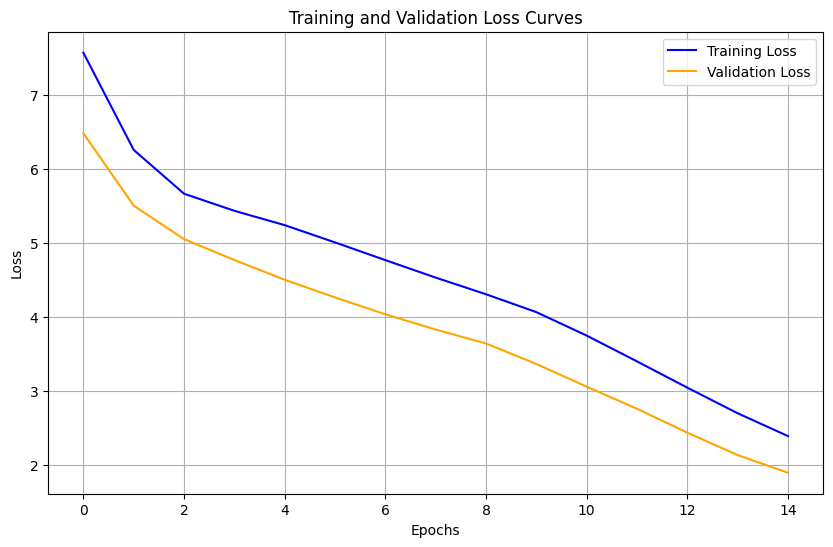

In [43]:
import matplotlib.pyplot as plt
# Extract the loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), train_loss, label='Training Loss', color='blue')
plt.plot(range(epochs), val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()